In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-12 17:27:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-07-12 17:27:41 (11.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-07-12 17:27:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.174.207, 74.125.23.207, 74.125.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.174.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  20.1MB/s    in 25s     

2024-07-12 17:28:07 (19.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
import os

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.

In [ ]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [ ]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 384, 3)


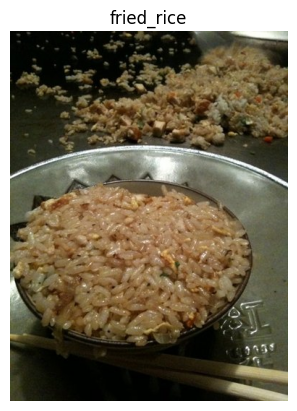

In [ ]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical", batch_size = 32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

# Create a frozen base model
# Setup the input shape to our model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)


# 9. Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

24274472/24274472 [==============================] - 2s 0us/step


In [ ]:
initial_epochs = 5
historyg = model.fit(train_data, epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                       )

Epoch 1/5
235/235 [==============================] - 204s 822ms/step - loss: 1.0679 - accuracy: 0.6865 - val_loss: 0.5147 - val_accuracy: 0.8553
Epoch 2/5
235/235 [==============================] - 125s 529ms/step - loss: 0.6723 - accuracy: 0.7896 - val_loss: 0.3751 - val_accuracy: 0.8931
Epoch 3/5
235/235 [==============================] - 99s 419ms/step - loss: 0.5963 - accuracy: 0.8148 - val_loss: 0.3844 - val_accuracy: 0.8849
Epoch 4/5
235/235 [==============================] - 79s 335ms/step - loss: 0.5543 - accuracy: 0.8236 - val_loss: 0.3555 - val_accuracy: 0.9030
Epoch 5/5
235/235 [==============================] - 74s 311ms/step - loss: 0.5245 - accuracy: 0.8333 - val_loss: 0.3126 - val_accuracy: 0.9128


In [ ]:
results = model.evaluate(test_data)
results

79/79 [==============================] - 7s 87ms/step - loss: 0.3153 - accuracy: 0.9008


[0.31525206565856934, 0.9007999897003174]

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def load_and_prep_img(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor, and reshapes it into
    (img_shape, img_shape, 3).
    """
    # Read in the image
    img = tf.io.read_file(filename)

    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])

    if scale:
        # Rescale the image (get all values between 0 and 1)
        img = img / 255.
    return img

def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model, and plots the image with the predicted class as the title.
    """
    original_img = tf.io.read_file(filename)
    original_img = tf.image.decode_jpeg(original_img, channels=3)
    # Import the target image and preprocess it
    img = load_and_prep_img(filename,scale = False)

    plt.axis(False)
    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class index
    pred_index = tf.argmax(pred, axis=1).numpy()[0]

    # Get the predicted class probabilities
    class_probabilities = pred.squeeze()
    # Print the predicted index
    print(f"Predicted index: {pred_index+1}")
    print(f"Probabilities for each class: {tf.round(class_probabilities*100.00)}%")


    # Get the predicted class
    pred_class = class_names[pred_index]

    # Plot the image and predicted class
    plt.imshow(original_img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    plt.show()


In [ ]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-steak.jpeg?raw=true


--2024-07-12 17:52:45--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-steak.jpeg?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/03-steak.jpeg [following]
--2024-07-12 17:52:46--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/03-steak.jpeg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg [following]
--2024-07-12 17:52:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.co

In [ ]:
from PIL import Image

# Open the image file
try:
    with Image.open("/content/10_food_classes_all_data/test/chicken_wings/1010547.jpg") as img:
        print(f"Image format: {img.format}")
        img.show()
except Exception as e:
    print(f"Error opening image: {e}")


Image format: JPEG


1/1 [==============================] - 0s 52ms/step
Predicted index: 9
Probabilities for each class: [ 0.  0.  1. 16.  1.  0.  0.  0. 81.  1.]%


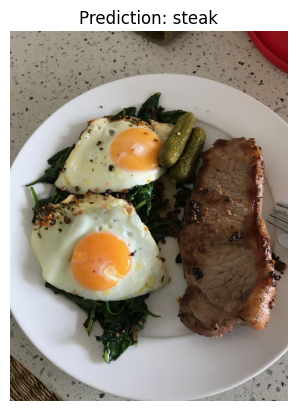

In [ ]:
pred_and_plot(model,"/content/03-steak.jpeg?raw=true",class_names)

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])


In [ ]:
fine_tune_epochs = initial_epochs + 1
history_fine_tune= model.fit(train_data,
                                          epochs=fine_tune_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          initial_epoch=historyg.epoch[-1]
                                       )

Epoch 5/6
235/235 [==============================] - 86s 327ms/step - loss: 0.5519 - accuracy: 0.8184 - val_loss: 0.2879 - val_accuracy: 0.9079
Epoch 6/6
235/235 [==============================] - 66s 274ms/step - loss: 0.4106 - accuracy: 0.8647 - val_loss: 0.2303 - val_accuracy: 0.9260


In [ ]:
new_results = model.evaluate(test_data)
new_results

79/79 [==============================] - 5s 59ms/step - loss: 0.2269 - accuracy: 0.9276


[0.22694481909275055, 0.9276000261306763]

--2024-07-12 17:42:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-07-12 17:42:12 (10.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



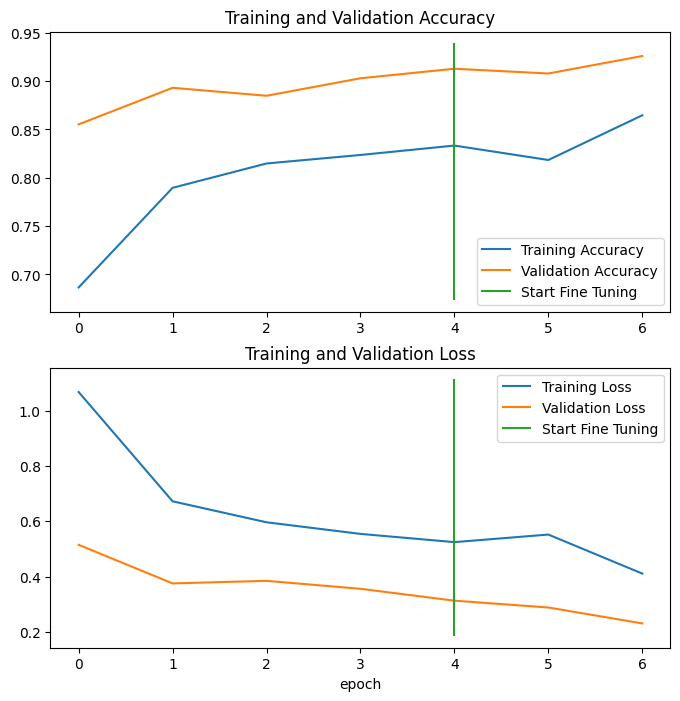

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import compare_historys
compare_historys(historyg, history_fine_tune,)

--2024-07-12 17:53:50--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-pizza-dad.jpeg?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/03-pizza-dad.jpeg [following]
--2024-07-12 17:53:51--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/03-pizza-dad.jpeg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg [following]
--2024-07-12 17:53:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.

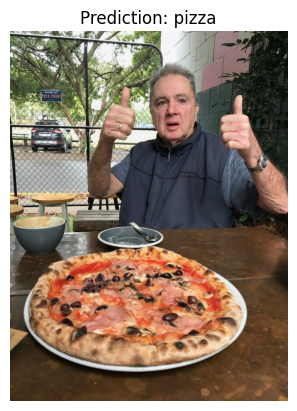

In [ ]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-pizza-dad.jpeg?raw=true

pred_and_plot(model,"03-pizza-dad.jpeg?raw=true",class_names)

--2024-07-12 17:54:00--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-sushi.jpeg?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/03-sushi.jpeg [following]
--2024-07-12 17:54:01--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/03-sushi.jpeg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg [following]
--2024-07-12 17:54:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.co

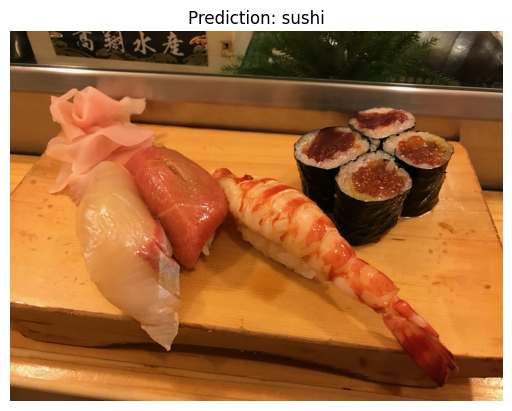

In [ ]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-sushi.jpeg?raw=true

pred_and_plot(model,"03-sushi.jpeg?raw=true",class_names)

--2024-07-12 17:54:09--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-hamburger.jpeg?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/03-hamburger.jpeg [following]
--2024-07-12 17:54:09--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/03-hamburger.jpeg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg [following]
--2024-07-12 17:54:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.

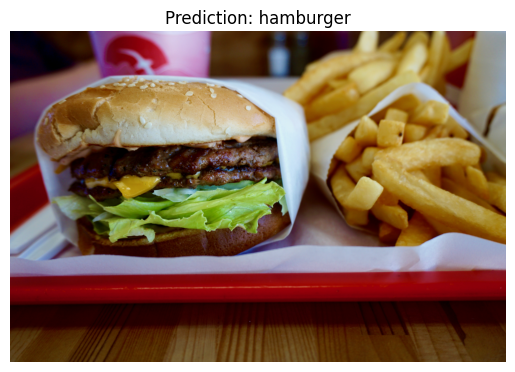

In [ ]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-hamburger.jpeg?raw=true
pred_and_plot(model,"03-hamburger.jpeg?raw=true",class_names)

In [ ]:
model_save_path = '/content/Final_model.h5'
model.save(model_save_path)
from google.colab import files
files.download(model_save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>